<a href="https://colab.research.google.com/github/sai8e/StockMarketProject/blob/main/Jonathan_Nope_Using_Python_%26_Machine_Learning_to_Predict_Stock_Prices_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Description: This Program uses an artifical recurrent neural network called Long Short Term Memory (LSTM)
#              to predict the closing stock price of a corporation (Apple Inc.) using past 60 day stock price.

In [2]:
!pip install yfinance
!pip install requests
!pip install lxml
!pip install numpy
!pip install pandas
!pip install --upgrade pandas-datareader
!pip install --upgrade yfinance

In [3]:
# Import the Libraries
import math
import pandas_datareader as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import io
import os
import csv
import glob
from google.colab import files

In [4]:
#Declare Variables
file_ex = ".csv"
compare_data = 'Close'
date = dt.datetime.now()
end_date = date.strftime('%Y') + '-' + date.strftime('%m') + '-' + date.strftime('%d')
start_date = str(int(date.strftime('%Y')) - 10) + '-' + date.strftime('%m') + '-' + date.strftime('%d')

In [5]:
#Declare Ticker
all_filenames = [i for i in glob.glob(f"*{file_ex}")]
for file in all_filenames:
    os.remove(file)
while True:
  ticker = input('Please input Ticker (Example "AAPL"):')
  try:
    add_avg = []
    add_dayChange = []
    df = pdr.get_data_yahoo(ticker, start_date, end_date)
    previousAVG = 0
    open_list = df['Open'].tolist()
    close_list = df['Close'].tolist()
    for i in range(len(open_list)):
        dayAVG = (open_list[i] + close_list[i]) / 2
        add_avg.append(dayAVG)
        dayAVGChange = (dayAVG - previousAVG)
        previousAVG = dayAVG
        add_dayChange.append(dayAVGChange)
    AVG = np.array(add_avg)
    dChange = np.array(add_dayChange)
    df['Average'] = AVG.tolist()
    df['AVGChange'] = dChange.tolist()
    df.to_csv(ticker + file_ex)
    df = pd.read_csv(ticker + file_ex)
    break
  except:
    print('Sorry Ticker is not in database! Please Try Again')

Please input Ticker (Example "AAPL"):BABA


In [6]:
print('TICKER: '+ ticker)
print(df)

TICKER: BABA
            Date        High         Low  ...   Adj Close     Average  AVGChange
0     2014-09-19   99.699997   89.949997  ...   93.889999   93.294998  93.294998
1     2014-09-22   92.949997   89.500000  ...   89.889999   91.294998  -2.000000
2     2014-09-23   90.480003   86.620003  ...   87.169998   88.055000  -3.239998
3     2014-09-24   90.570000   87.220001  ...   90.570000   89.520000   1.465000
4     2014-09-25   91.500000   88.500000  ...   88.919998   90.004997   0.484997
...          ...         ...         ...  ...         ...         ...        ...
1790  2021-10-28  170.350006  166.770004  ...  169.789993  169.139999   0.760002
1791  2021-10-29  168.559998  162.720001  ...  164.940002  166.005005  -3.134995
1792  2021-11-01  171.895004  165.800003  ...  170.169998  168.004997   1.999992
1793  2021-11-02  167.100006  162.759995  ...  162.899994  165.000000  -3.004997
1794  2021-11-03  166.639999  163.509995  ...  166.240005  165.800003   0.800003

[1795 rows x 9

In [7]:
df.shape

(1795, 9)

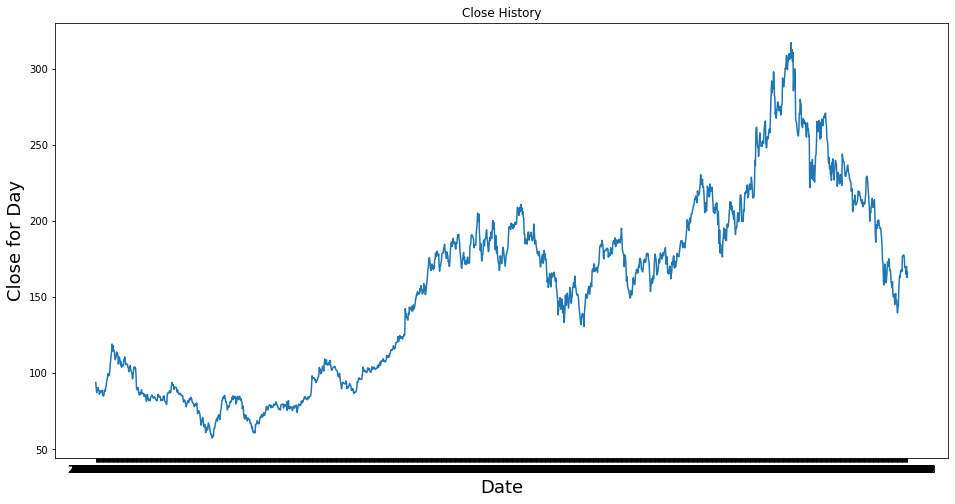

In [8]:
#Visualize Close Price
plt.figure(figsize=(16,8))
plt.title(compare_data + ' History')
plt.plot(df['Date'], df[compare_data])
plt.xlabel('Date', fontsize=18)
plt.ylabel(compare_data +' for Day', fontsize=18)
plt.show()

In [9]:
# create a new dataframe  with only the comapre_data column
data = df.filter([compare_data])
# convert the dataframe to a numpy array
dataset = data.values
# get the number of rows to train the LSTM model
training_data_len = math.ceil(len(dataset)*.80)


In [10]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [11]:
# Create the training dataset
# Create the scaled training dataset
train_data = scaled_data[0:training_data_len , :]
# split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
   x_train.append(train_data[i-60:i, 0])
   y_train.append(train_data[i, 0])

In [12]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [13]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1376, 60, 1)

In [14]:
# Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1376/1376 [==============================] - 47s 32ms/step - loss: 0.0018


In [17]:
# Create testing dataset
# Create new array containing scaled values 
test_data = scaled_data[training_data_len - 60: , :]
# Create data set x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])
  

In [18]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [19]:
# Reshape data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(359, 60, 1)

In [20]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


In [21]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions- y_test)**2)
rmse

1.3715487084348879

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


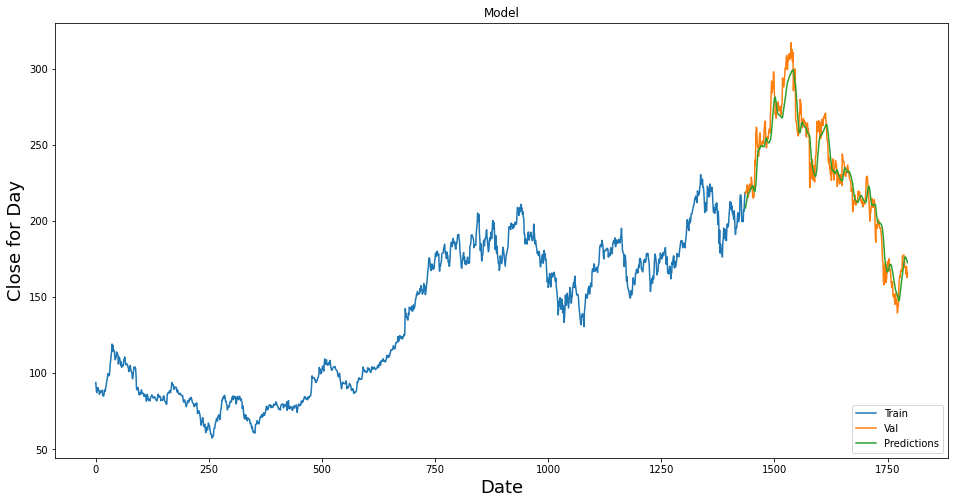

In [22]:
# Plot the date
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel(compare_data +' for Day', fontsize=18)
plt.plot(train[compare_data])
plt.plot(valid[[compare_data, 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [23]:
# Show the valid and predicted price
valid

,Close,Predictions
1436,218.039993,208.517761
1437,219.550003,210.323669
1438,219.000000,212.241806
1439,220.720001,213.972595
1440,223.679993,215.610931
...,...,...
1790,169.789993,176.221725
1791,164.940002,175.764481
1792,170.169998,174.692047
1793,162.899994,173.902145
